In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import numpy as np
import glob
import os
import xlwt
import openpyxl
import rasterio
from astropy.convolution import convolve, convolve_fft

#root = 'C:/Users/mathi/My Drive (thesis20212022@gmail.com)'
root = 'C:/Users/Rasmus/Mit drev (thesis20212022@gmail.com)'
all_files = glob.glob(root + '/Validation/SeNorgeCSVs/*.csv')

# Sample heights from DEM into station shapefile
DEM = root + r'\Norway\DEM/mergedDEM10_All_Norway.tif'
stations = gpd.read_file(root + '/Validation/StationShapefiles/InSituStations.shp')

coords = [(x,y) for x, y in zip(stations.geometry.x, stations.geometry.y)]
src = rasterio.open(DEM)
stations['DEM'] = [x[0] for x in src.sample(coords)]

stations

,id,Stasjon,Elevation,Name,geometry,DEM
0,0,SN40880,843,Hovden - Lundane,POINT (70498.279 6628657.259),841.536865
1,0,SN40905,988,Rv9 Hovden,POINT (75218.855 6635586.552),914.637268
2,0,SN33950,986,Haukeliseter Testfelt,POINT (64054.684 6655966.951),985.607849
3,0,SN46430,997,Røldalsfjellet,POINT (37357.270 6661558.671),997.143982
4,0,SN29400,1247,Sandhaug,POINT (83510.005 6695603.580),1246.882690
5,0,SN31620,973,Møsstrand Ii,POINT (118122.768 6653243.171),973.284302
6,0,SN31520,970,Groset,POINT (125685.036 6652008.750),950.889648
7,0,SN31660,952,Mogen,POINT (105453.044 6674537.408),951.679077
8,0,SN49860,1231,Rv7 Dyranut,POINT (86674.119 6716074.395),1231.110229
9,0,SN29900,1247,Skurdevikåi,POINT (90912.526 6716563.445),1247.499268


In [2]:
station_obs = pd.read_excel(root + '/Validation/StationXLS/StationObservations2.xls')
#station_obs = pd.read_excel(root + '/Validation/StationXLS/StationObservations_temp&SD.xls')

# Set station name
#stationsnavn = 'Røldalsfjellet'

# Set start and end date of interest - format: yyyy-mm-dd
startdate = '2019-01-01'
enddate = '2019-05-01'

# Get df with only of unique station names and IDs
unique = station_obs.drop_duplicates(subset=['Navn'])
unique = unique.drop(columns=['Tid(norsk normaltid)','Snødybde'])

unique.sort_values(by=['Stasjon'], ascending=True)

,Navn,Stasjon
0,Øvre Heimdalsvatn,SN13750
365,Fv51 Valdresflye,SN13760
546,Juvvasshøe,SN15270
1368,Rv15 Breidalen,SN15950
2349,Høvringen Ii,SN16271
3413,Fokstugu,SN16610
4475,Beitostølen Ii,SN23550
5528,Finsevatn,SN25830
6556,Sandhaug,SN29400
7604,Skurdevikåi,SN29900


In [3]:
### Preparing first-hand observation data

firsthand_obs = pd.read_excel(root + '/Validation/FirsthandObsAverage.xls')
firsthand_obs['Tid'] = pd.to_datetime(firsthand_obs['Date'], format='%d.%m.%Y')

firsthand_obs

,SD,Date,Tid
0,161,24.02.2022,2022-02-24


In [4]:
### Preparing station data

# Filter out dates that only have no temp or SD values
#station_obs = station_obs.loc[station_obs['Middeltemperatur (døgn)'] != '-']
#station_obs = station_obs.loc[station_obs['Snødybde'] != '-']

# Filter by date interval
station_obs = station_obs.rename(columns={'Tid(norsk normaltid)':'Tid','Snødybde':'SD_Station'})
station_obs['Tid'] = pd.to_datetime(station_obs['Tid'], format='%d.%m.%Y')
station_obs = station_obs[(station_obs['Tid'] > startdate) & (station_obs['Tid'] < enddate)]
station_obs = station_obs.groupby('Tid', as_index=False, sort=False)['SD_Station'].mean()
station_obs

,Tid,SD_Station
0,2019-01-02,40.500000
1,2019-01-03,41.142857
2,2019-01-04,40.357143
3,2019-01-05,35.285714
4,2019-01-06,34.357143
...,...,...
114,2019-02-15,53.181818
115,2019-03-31,66.250000
116,2019-04-10,56.181818
117,2019-04-11,55.545455


In [5]:
### Preparing SeNorge data

# Read SeNorge .csv files and put in a list for dataframe concatenation
li = []
for csv in all_files:
    df = pd.read_csv(csv, index_col=None, header=1, delimiter=';')
    df['Navn'] = os.path.basename(csv).split('.')[0]
    li.append(df)
senorge_pred = pd.concat(li, axis=0, ignore_index=True)
print(unique.sort_values(by=['Stasjon'], ascending=True))
# Filter by station name
#CHANGED
#senorge_pred = senorge_pred.loc[senorge_pred['Navn'] == stationsnavn]
#senorge_pred = senorge_pred.drop(columns=['Navn'])
# Filter by date interval
senorge_pred = senorge_pred.rename(columns={'Date':'Tid'})
senorge_pred['Tid'] = senorge_pred['Tid'].str.slice(0,10)
senorge_pred['Tid'] = pd.to_datetime(senorge_pred['Tid'], format='%d.%m.%Y')
senorge_pred = senorge_pred[(senorge_pred['Tid'] > startdate) & (senorge_pred['Tid'] < enddate)]
print(senorge_pred)


# Filter out invalid observation
senorge_pred = senorge_pred.rename(columns={'sd(cm)': 'SD_SeNorge'})
senorge_pred = senorge_pred.loc[senorge_pred['SD_SeNorge'] != 65535.0]

senorge_pred = senorge_pred.groupby('Tid', as_index=False, sort=False)['SD_SeNorge'].mean()
senorge_pred

                        Navn  Stasjon
0          Øvre Heimdalsvatn  SN13750
365         Fv51 Valdresflye  SN13760
546               Juvvasshøe  SN15270
1368          Rv15 Breidalen  SN15950
2349            Høvringen Ii  SN16271
3413                Fokstugu  SN16610
4475          Beitostølen Ii  SN23550
5528               Finsevatn  SN25830
6556                Sandhaug  SN29400
7604             Skurdevikåi  SN29900
7732                  Groset  SN31520
8227            Møsstrand Ii  SN31620
9291                   Mogen  SN31660
10160  Haukeliseter Testfelt  SN33950
11201       Hovden - Lundane  SN40880
11719             Rv9 Hovden  SN40905
12320         Røldalsfjellet  SN46430
13363            Rv7 Dyranut  SN49860
13761    Myrkdalen-vetlebotn  SN51990
14826         Rv13 Vikafjell  SN53010
15833              Midtstova  SN53530
              Tid  sd(cm)               Navn
22646  2019-01-02    43.5     Beitostølen Ii
22647  2019-01-03    43.0     Beitostølen Ii
22648  2019-01-04    42.5    

,Tid,SD_SeNorge
0,2019-01-02,53.265217
1,2019-01-03,52.952174
2,2019-01-04,52.695652
3,2019-01-05,49.821739
4,2019-01-06,48.417391
...,...,...
114,2019-04-26,64.713043
115,2019-04-27,60.769565
116,2019-04-28,57.056522
117,2019-04-29,53.395652


In [6]:
### Combine dataframes

merged_df = pd.merge(station_obs, senorge_pred, on='Tid')

# Filter out observations with 0 SD in both columns
merged_df = merged_df.loc[(merged_df['SD_Station'] !=0) | merged_df['SD_SeNorge'] !=0]

merged_df

,Tid,SD_Station,SD_SeNorge
0,2019-01-02,40.500000,53.265217
1,2019-01-03,41.142857,52.952174
2,2019-01-04,40.357143,52.695652
3,2019-01-05,35.285714,49.821739
4,2019-01-06,34.357143,48.417391
...,...,...,...
114,2019-02-15,53.181818,88.682609
115,2019-03-31,66.250000,110.865217
116,2019-04-10,56.181818,100.917391
117,2019-04-11,55.545455,100.508696


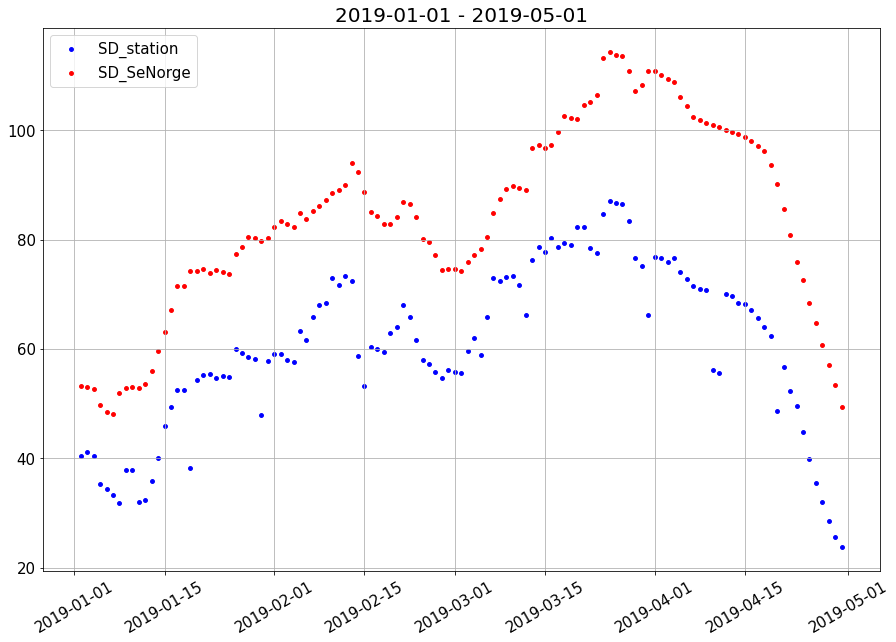

In [7]:
# Create template and choose window size
plt.figure(figsize = (15, 10))

# Generate title based on entered dates
plt.title(startdate +' - ' + enddate, fontsize=20)

# Configure x-axis date labels
plt.xticks(rotation=30, fontsize=15)
myFmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(myFmt)

# Configure y-axis labels
plt.yticks(fontsize = 15)

# Show grid
plt.grid(True)

# Generate plot
plt.scatter(merged_df.Tid, merged_df.SD_Station, color='blue', s=15, label='SD_station')
plt.scatter(merged_df.Tid, merged_df.SD_SeNorge, color='red', s=15, label='SD_SeNorge')
plt.legend(loc='upper left', prop={'size': 15})

In [8]:
merged_df

,Tid,SD_Station,SD_SeNorge
0,2019-01-02,40.500000,53.265217
1,2019-01-03,41.142857,52.952174
2,2019-01-04,40.357143,52.695652
3,2019-01-05,35.285714,49.821739
4,2019-01-06,34.357143,48.417391
...,...,...,...
114,2019-02-15,53.181818,88.682609
115,2019-03-31,66.250000,110.865217
116,2019-04-10,56.181818,100.917391
117,2019-04-11,55.545455,100.508696


In [9]:
#stations_sampled = gpd.read_file(root + '/Validation/StationShapefiles/InSituStations_sampled_2.shp')
stations_sampled = gpd.read_file(root + '/Validation/StationShapefiles/InSituStations_sampled_full.shp')

In [10]:
#stations_sampled = stations_sampled.loc[stations_sampled ['Name'] == stationsnavn]

stations_sampled = stations_sampled[stations_sampled['SD_Model'] > 0]
stations_sampled['SD_Model'] = stations_sampled['SD_Model'] * 100

stations_sampled['Sample_Dat'] = pd.to_datetime(stations_sampled['Sample_Dat'], format='%Y-%m-%d')

stations_sampled = stations_sampled.groupby('Sample_Dat', as_index=False, sort=False)['SD_Model'].mean()

stations_sampled

,Sample_Dat,SD_Model
0,2016-12-07,106.029074
1,2016-12-13,142.352407
2,2016-12-19,92.536779
3,2016-12-25,165.955001
4,2016-12-31,68.660961
...,...,...
157,2022-03-05,196.886016
158,2022-03-17,178.390121
159,2022-03-29,134.769991
160,2022-04-10,130.741692


In [11]:
mergedf2 = merged_df.merge(stations_sampled, left_on = "Tid", right_on = "Sample_Dat", how = "left")

In [12]:
from astropy.convolution import Gaussian1DKernel
gauss_1D_kernel = Gaussian1DKernel(5)
#kernel_size = 111
#kernel = np.ones(kernel_size) / kernel_size
mergedf2.loc[mergedf2['SD_Model'] == -999 ,'SD_Model'] = np.nan
mergedf2['SD_Model_smooth'] = convolve(mergedf2.SD_Model, gauss_1D_kernel, boundary='extend')
mergedf2.loc[mergedf2['SD_Model'] == np.nan ,'SD_Model_smooth'] = np.nan
mergedf2

,Tid,SD_Station,SD_SeNorge,Sample_Dat,SD_Model,SD_Model_smooth
0,2019-01-02,40.500000,53.265217,2019-01-02,55.717184,59.116444
1,2019-01-03,41.142857,52.952174,NaT,NaN,60.553129
2,2019-01-04,40.357143,52.695652,NaT,NaN,62.427098
3,2019-01-05,35.285714,49.821739,NaT,NaN,64.780116
4,2019-01-06,34.357143,48.417391,NaT,NaN,67.598997
...,...,...,...,...,...,...
114,2019-02-15,53.181818,88.682609,NaT,NaN,83.918768
115,2019-03-31,66.250000,110.865217,NaT,NaN,83.171195
116,2019-04-10,56.181818,100.917391,NaT,NaN,82.722379
117,2019-04-11,55.545455,100.508696,NaT,NaN,82.463742


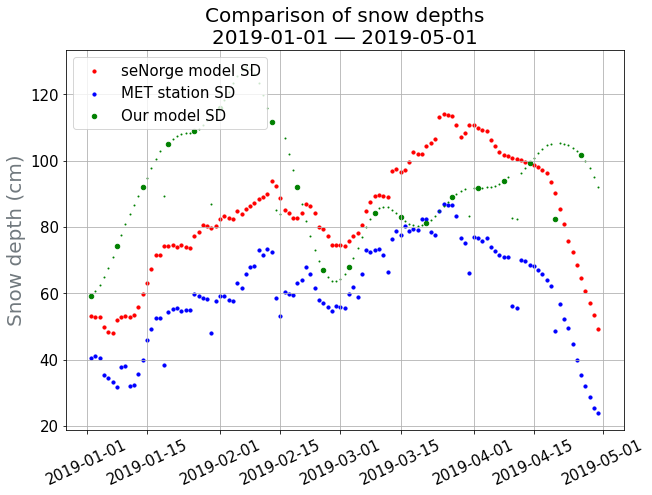

In [13]:
# Create template and choose window size
plt.figure(figsize = (10, 7))

# Generate title based on entered dates
plt.title('Comparison of snow depths\n' + startdate +' ― ' + enddate, fontsize=20)

# Configure x-axis date labels
plt.xticks(rotation=25, fontsize=15)
myFmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(myFmt)

# Configure y-axis labels
plt.yticks(fontsize = 15)
plt.ylabel('Snow depth (cm)',color='#71797E',fontsize = 20)

# Show grid
plt.grid(True)

# Generate plot
plt.scatter(mergedf2.Tid, mergedf2.SD_SeNorge, color='red', s=10, label='seNorge model SD')
plt.scatter(mergedf2.Tid, mergedf2.SD_Station, color='blue', s=10, label='MET station SD')
plt.scatter(mergedf2.Tid, mergedf2.SD_Model_smooth, color='green', s=1)
plt.scatter(mergedf2.Sample_Dat, mergedf2.SD_Model_smooth, color='green', s=20, label='Our model SD')
#plt.scatter(firsthand_obs.Tid, firsthand_obs.SD, color='purple', s=100, label='First-hand SD')
#plt.scatter(mergedf2.Tid, mergedf2.SD_Model, color='purple', s=10, label='SD_SeNorge')

plt.legend(loc='upper left', prop={'size': 15})

#plt.savefig(root + r'/Figures/Comparison of snow depths (2022).png', dpi = 600)

In [14]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
r2df = pd.DataFrame(mergedf2.dropna())
r2 = r2_score(mergedf2.SD_Station, mergedf2.SD_Model_smooth).round(2)
r2 = format(r2, '.2f')
print('Our model vs MET')
print('r2:', r2)
rms = mean_squared_error(mergedf2.SD_Station, mergedf2.SD_Model_smooth, squared=False).round(2)
print('RMSE: ', rms,'cm')

mae = mean_absolute_error(mergedf2.SD_Station, mergedf2.SD_Model_smooth).round(2)
print('MAE: ', mae,'cm')

Our model vs MET
r2: -5.52
RMSE:  38.18 cm
MAE:  31.88 cm


In [15]:
r2 = r2_score(mergedf2.SD_SeNorge, mergedf2.SD_Model_smooth).round(2)
r2 = format(r2, '.2f')
print('Our model vs seNorge')
print('r2', r2)
rms = mean_squared_error(mergedf2.SD_SeNorge, mergedf2.SD_Model_smooth, squared=False).round(2)
print('RMSE_train: ', rms)

mae = mean_absolute_error(mergedf2.SD_SeNorge, mergedf2.SD_Model_smooth).round(2)
print('MAE_train: ', mae)

Our model vs seNorge
r2 -0.85
RMSE_train:  23.64
MAE_train:  20.33


In [16]:
r2 = r2_score(mergedf2.SD_Station, mergedf2.SD_SeNorge).round(2)
r2 = format(r2, '.2f')
print('seNorge vs MET')
print('r2', r2)

rms = mean_squared_error(mergedf2.SD_Station, mergedf2.SD_SeNorge, squared=False).round(2)
print('RMSE_train: ', rms)

mae = mean_absolute_error(mergedf2.SD_Station, mergedf2.SD_SeNorge).round(2)
print('MAE_train: ', mae)

seNorge vs MET
r2 -1.74
RMSE_train:  24.76
MAE_train:  23.73
